### I. Chargement des libraries



In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import Classifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time
import warnings
import pickle


In [77]:
sns.set(style="darkgrid")
np.random.seed(seed=314)
warnings.filterwarnings("ignore")

## II. Chargement et exploration des données

In [78]:
df = pd.read_csv("F:/data_v1.0.csv",header=0)
df.drop(columns=['Unnamed: 0', 'index', 'date'], inplace=True)


In [79]:
df.head(3)

,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0


In [80]:
df.dtypes

cheveux        object
age           float64
exp           float64
salaire       float64
sexe           object
diplome        object
specialite     object
note          float64
dispo          object
embauche        int64
dtype: object

In [81]:
df['embauche'] = df['embauche'].astype('category')
df['cheveux'] = df['cheveux'].astype('category')
df['sexe'] = df['sexe'].astype('category')
df['diplome'] = df['diplome'].astype('category')

df['specialite'] = df['specialite'].astype('category')
df['diplome'] = df['diplome'].astype('category')
df['dispo'] = df['dispo'].astype('category')



In [82]:
## Variable manquantes
df.columns[df.isnull().any()]

Index(['cheveux', 'age', 'exp', 'salaire', 'sexe', 'diplome', 'specialite',
       'note', 'dispo'],
      dtype='object')

In [83]:
## Taux de valeurs manquantes par variables
miss = df.isna().sum()*100/df.shape[0]
miss = miss[miss>0]
miss.sort_values(inplace=True, ascending=False)
df_na = miss.reset_index()
df_na.columns = ['Variable', 'taux']
df_na

,Variable,taux
0,note,0.570
1,diplome,0.550
2,dispo,0.530
3,cheveux,0.515
4,sexe,0.500
5,exp,0.480
6,salaire,0.475
7,specialite,0.465
8,age,0.455


In [84]:
## Visualisation de valeurs manquantes

def barplot_cust_1(df, x_var, y_var, label_y="Fréquence(%)", lab=True):
    
    fig, axes = plt.subplots( figsize=(15, 8), sharey=True)

    bar1 = sns.barplot(ax=axes ,x = x_var,  y= y_var, data=df, color='#66b3ff')
    bar1.set_xticklabels(bar1.get_xticklabels(), rotation=45)

    nb_cat = df.shape[0]
    lab_bar = list(df[y_var])

    #  Ajout des labels 

    if lab:
        i = -1
        for bar in bar1.patches:
            if i<nb_cat-1:
                i+=1
                bar1.annotate(format(lab_bar[i], '.2f')+"%", (bar.get_x() + bar.get_width() / 2,
                                    bar.get_height()), ha='center', va='center',size=15, xytext=(0, -50),textcoords='offset points', color='white')

    axes.set_xlabel(xlabel=x_var, fontsize=15)
    axes.set_ylabel(ylabel=label_y, fontsize=15)

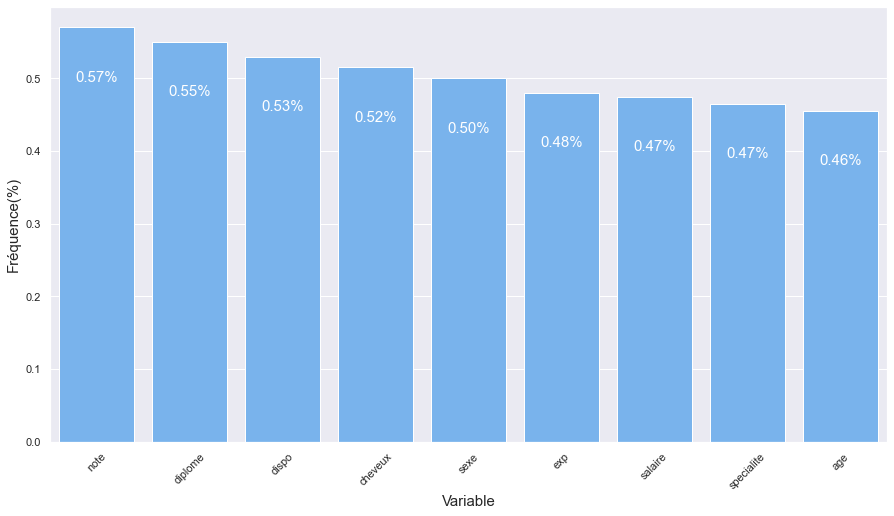

In [85]:
barplot_cust_1(df_na, "Variable", 'taux')

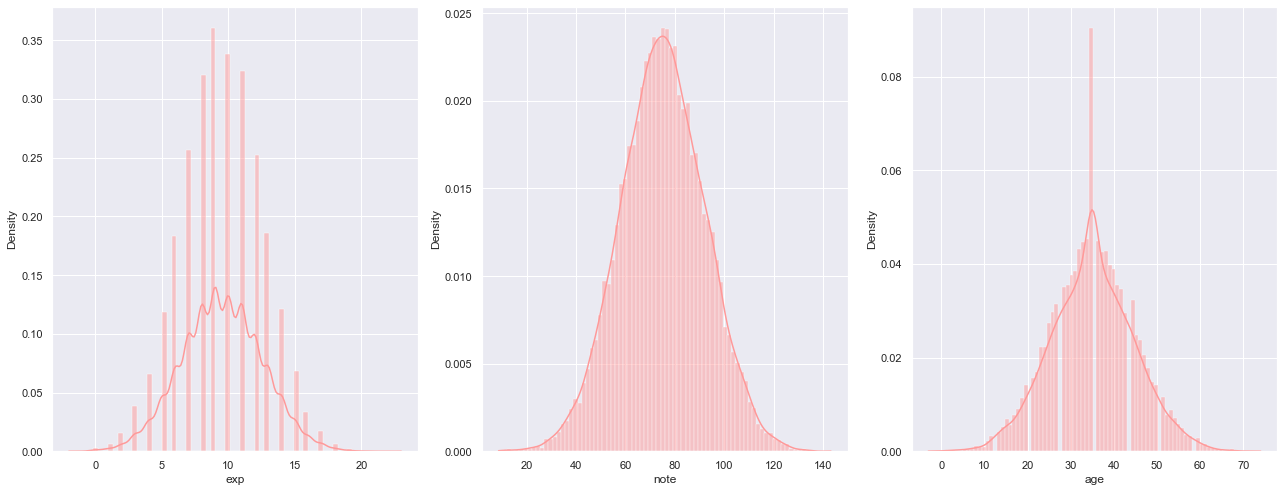

In [86]:

fig, axes = plt.subplots(1,3, figsize=(18, 7))   
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']             
sns.histplot(ax=axes[0],data=df, x='exp', stat='density', kde=True, color=colors[0])
sns.histplot(ax=axes[1],data=df, x='note', stat='density', kde=True, color=colors[0])
sns.histplot(ax=axes[2],data=df, x='age', stat='density', kde=True, color=colors[0])
fig.tight_layout()
plt.show()


In [87]:
# Imputation des variables manquantes

In [88]:
## 1. cheveux
df['cheveux'].fillna('chatain', inplace=True)
df['cheveux'].value_counts(normalize=True)

chatain    0.30625
brun       0.29955
blond      0.29645
roux       0.09775
Name: cheveux, dtype: float64

In [89]:
## 2. age 
df.loc[df.age<10, 'age'] = np.nan
df['age'].fillna(df['age'].median(skipna=True), inplace=True)
df['age'].describe()


count    20000.000000
mean        35.122150
std          9.404736
min         10.000000
25%         29.000000
50%         35.000000
75%         41.000000
max         74.000000
Name: age, dtype: float64

In [90]:
## 3. experience
df.loc[df.exp<0, 'exp' ] = 0
df['exp'].fillna(df['exp'].median(skipna=True), inplace=True)
df['exp'].describe()

count    20000.000000
mean         9.498100
std          3.004555
min          0.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         23.000000
Name: exp, dtype: float64

In [91]:
## 4. salaire
df['salaire'].fillna(df['salaire'].median(), inplace=True)
df['salaire'].describe()

count    20000.000000
mean     34974.366050
std       4991.202526
min      14128.000000
25%      31616.750000
50%      34979.000000
75%      38345.250000
max      53977.000000
Name: salaire, dtype: float64

In [92]:
## 5. sexe
df['sexe'].fillna('M', inplace=True)
df['sexe'].value_counts()

M    11989
F     8011
Name: sexe, dtype: int64

In [93]:
## 6. diplome
df['diplome'].fillna('master', inplace=True)
df['diplome'].value_counts(normalize=True)

master      0.38115
licence     0.36885
doctorat    0.12735
bac         0.12265
Name: diplome, dtype: float64

In [94]:
## 7. specialite
df['specialite'].fillna('geologie', inplace=True)
df['specialite'].value_counts(normalize=True)

geologie       0.50605
forage         0.21700
detective      0.20775
archeologie    0.06920
Name: specialite, dtype: float64

In [95]:
## 8. note
df['note'].fillna(df['note'].median(), inplace=True)
df['note'].describe()

count    20000.000000
mean        75.168256
std         17.047132
min          8.680000
25%         63.807500
50%         75.080000
75%         86.550000
max        143.220000
Name: note, dtype: float64

In [96]:
## 9. dispo
df['dispo'].fillna('non', inplace=True)
df['dispo'].value_counts(normalize=True)

non    0.5977
oui    0.4023
Name: dispo, dtype: float64

## III. Description des données

### III.1. Variables qualitatives : Camembert 

In [98]:
         
def custom_cam(var, num=2):

        colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
        fig, axes = plt.subplots(1, num, figsize=(30, 8), sharey=True)
        axe = -1

        for elt in var:
                axe +=1
                labels = list(df[elt].value_counts().index)
                sizes = list(df[elt].value_counts().values)

                exp_list = [0.1]+[0]*(len(labels)-1)
                explode = tuple(exp_list)

                axes[axe].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                shadow=True, startangle=90)

                #axes[axe].set_title(elt, fontsize=20)

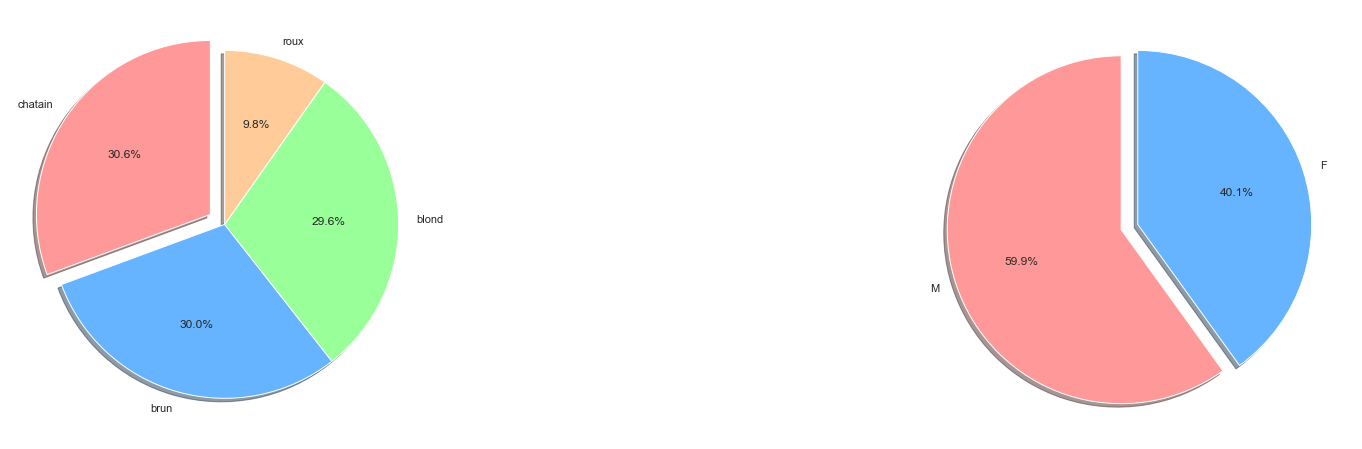

In [99]:
variable = ['cheveux', 'sexe']
custom_cam(variable)

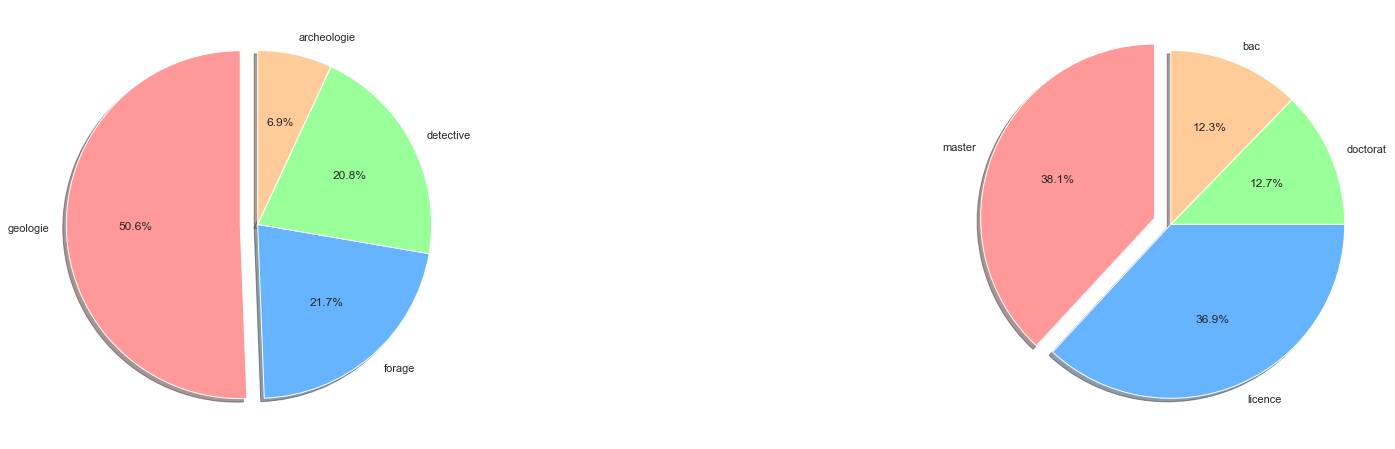

In [100]:
variable = ['specialite', 'diplome']
custom_cam(variable)

### III.2. variable cible vs variable catégorielle

In [101]:
df['total_pie'] = [1]*df.shape[0]

def barplot_cust(var):
    fig, axes = plt.subplots(1, 2, figsize=(30, 8), sharey=True)
    axe = -1
    for elt in var:
        axe +=1
        total = df.groupby(elt)['total_pie'].sum().reset_index()
        emb_1 = df[df.embauche==1].groupby(elt)['total_pie'].sum().reset_index()
        emb_1['total_pie'] = [i / j * 100 for i,j in zip(emb_1['total_pie'], total['total_pie'])]
        total['total_pie'] = [i / j * 100 for i,j in zip(total['total_pie'], total['total_pie'])]
        bar1 = sns.barplot(ax=axes[axe],x=elt,  y="total_pie", data=total, color='#ff9999')   
        bar2 = sns.barplot(ax=axes[axe],x=elt,  y="total_pie", data=emb_1, color='#66b3ff')


        nb_cat = df[elt].value_counts().shape[0]
        a = [elt.get_height() for elt in bar1.patches]
        lab_bar2 = a[-nb_cat:]
        lab_bar1 = [100-elt for elt in lab_bar2]

        #  Ajout des labels du premier et du deuxième barplot
        i = -1
        for bar in bar1.patches:
            if i<nb_cat-1:
                i+=1
                bar1.annotate(format(lab_bar1[i], '.2f')+"%", (bar.get_x() + bar.get_width() / 2,
                                    bar.get_height()), ha='center', va='center',size=15, xytext=(0, -100),textcoords='offset points', color='white')

        i=-1
        for bar in bar2.patches:
            if i<nb_cat-1:
                i+=1
                bar2.annotate(format(lab_bar2[i], '.2f')+"%", (bar.get_x() + bar.get_width() / 2,
                                    bar.get_height()), ha='center', va='center',size=15, xytext=(0, -400),textcoords='offset points')

        top_bar = mpatches.Patch(color='#ff9999', label='Embauche = 0')
        bottom_bar = mpatches.Patch(color='#66b3ff', label='Embauche = 1')
        axes[axe].legend(handles=[top_bar, bottom_bar])
        axes[axe].set_xlabel(xlabel=elt, fontsize=20)
        axes[axe].set_ylabel(ylabel="Fréquence(%)", fontsize=20)



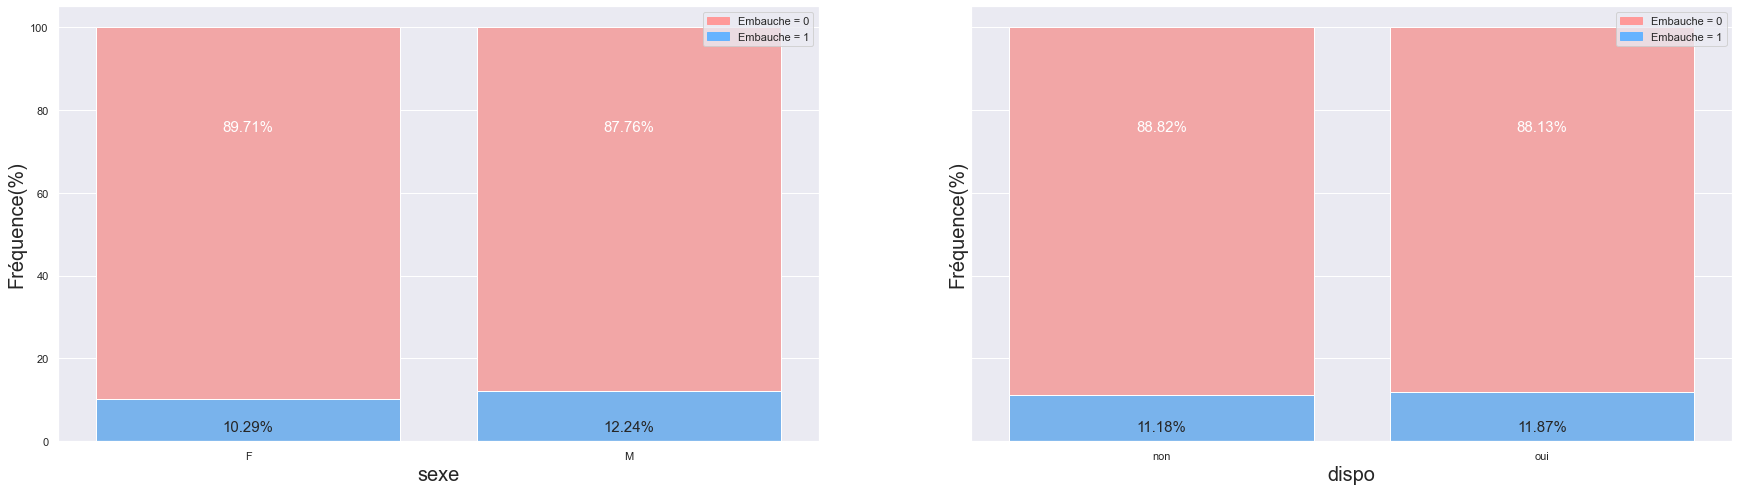

In [102]:
var = ["sexe", "dispo"]
barplot_cust(var)

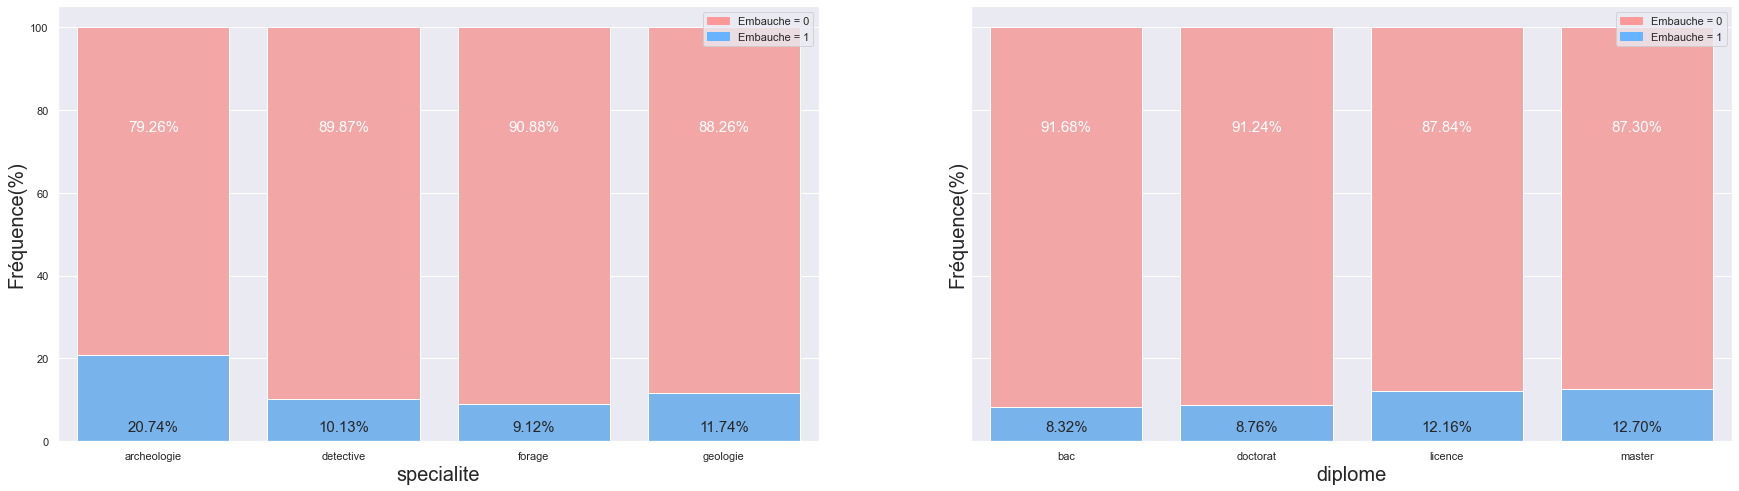

In [103]:
var = ["specialite", "diplome"]
barplot_cust(var)

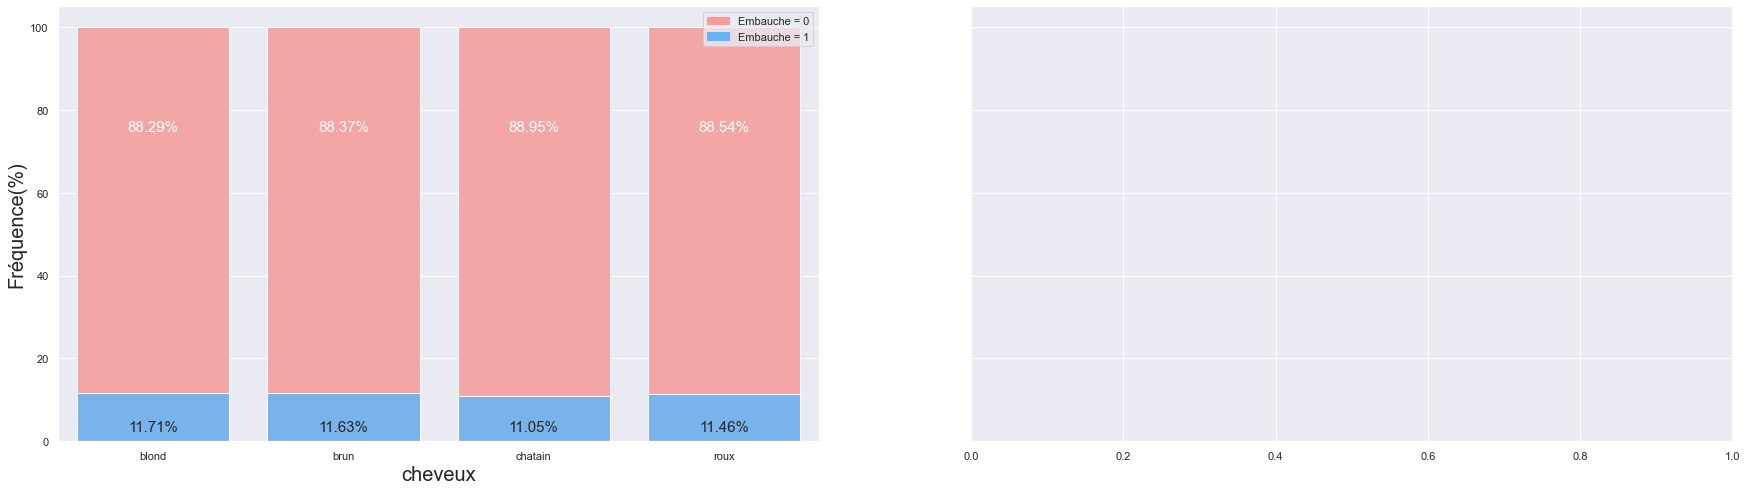

In [104]:
var = ["cheveux"]
barplot_cust(var)

### III.3. Variables quantitatives : tracé des boxplot

In [190]:
def boxplot(df, xlabel_,var_):
    fig, axes = plt.subplots(1, 2, figsize=(30, 4), sharey=True)
    fig.suptitle('Boxplot of quantitative variables')

    sns.boxplot(ax = axes[0], data=df, x=var_[0], color='#ff9999')
    axes[0].set(xlabel=xlabel_[0])

    sns.boxplot(ax = axes[1], data=df, x=var_[1], color='#66b3ff')
    axes[1].set(xlabel=xlabel_[1])


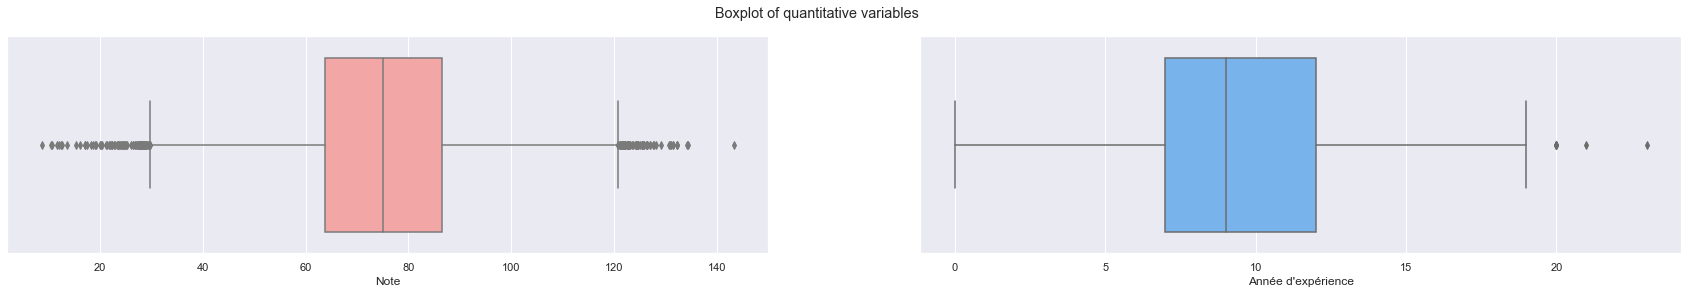

In [191]:
boxplot(df, var_=['note','exp'], xlabel_=['Note', "Année d'expérience"])

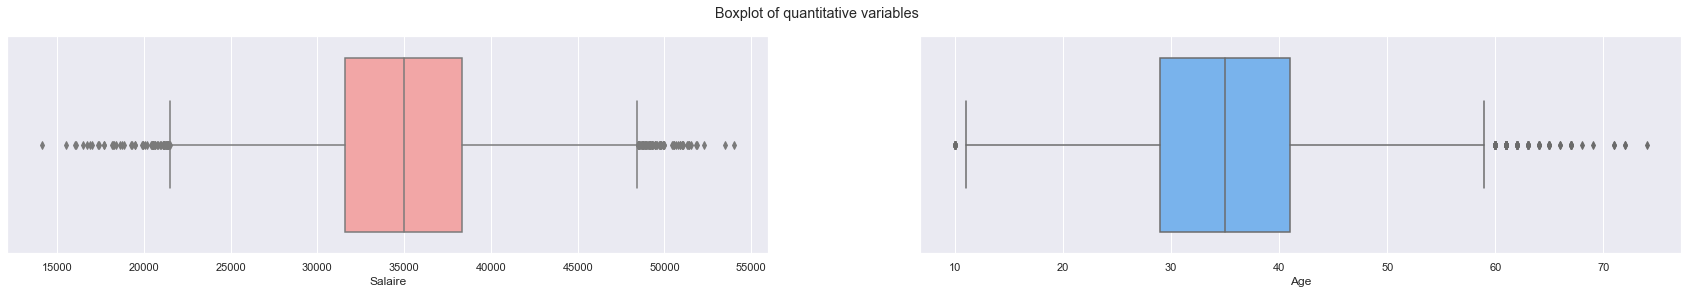

In [192]:
boxplot(df, var_=['salaire','age'], xlabel_=['Salaire', "Age"])

### III.4. Variables quantitatives : variable cible vs variable quantitatives

Text(0.5, 21.5, 'Salaire')

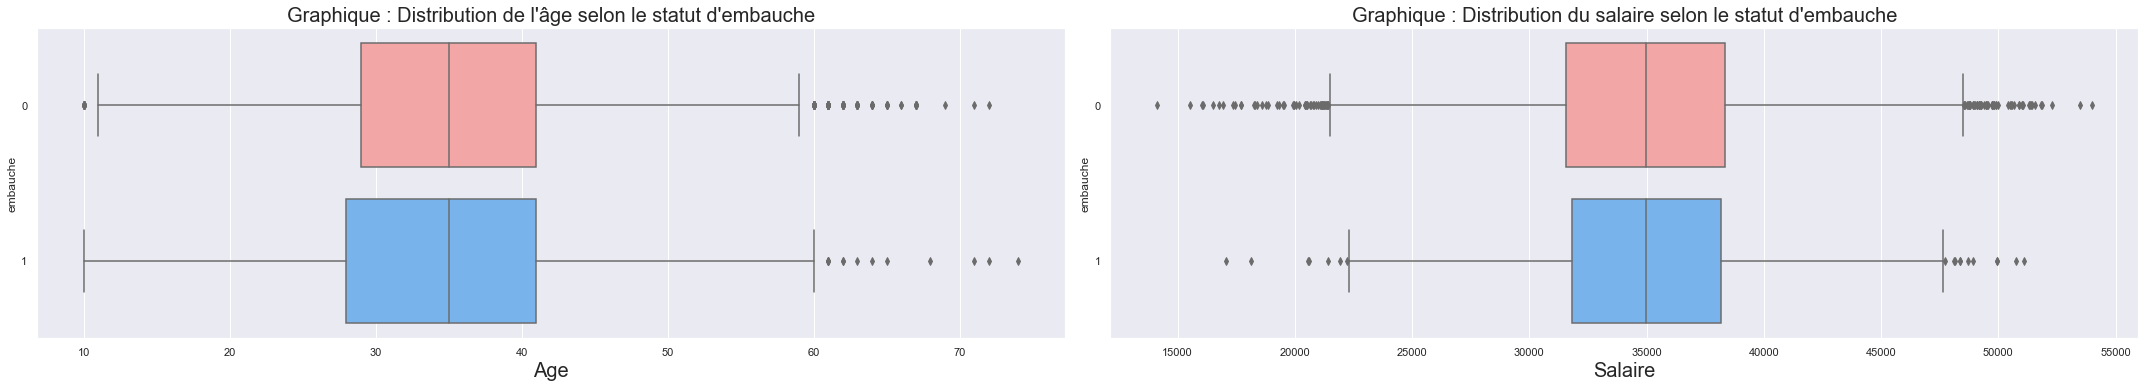

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(30, 5))
fig.tight_layout()
sns.set(style="darkgrid")
sns.boxplot(ax = axes[0], data=df, y='embauche', x='age', palette={'#ff9999','#66b3ff'})
axes[0].set_title("Graphique : Distribution de l'âge selon le statut d'embauche", fontsize=20)
axes[0].set_xlabel(xlabel="Age", fontsize=20)

sns.boxplot(ax = axes[1], data=df, y='embauche', x='salaire', palette={'#ff9999','#66b3ff'})
axes[1].set_title("Graphique : Distribution du salaire selon le statut d'embauche", fontsize=20)
axes[1].set_xlabel(xlabel="Salaire", fontsize=20)

Text(0.5, 21.5, 'Note')

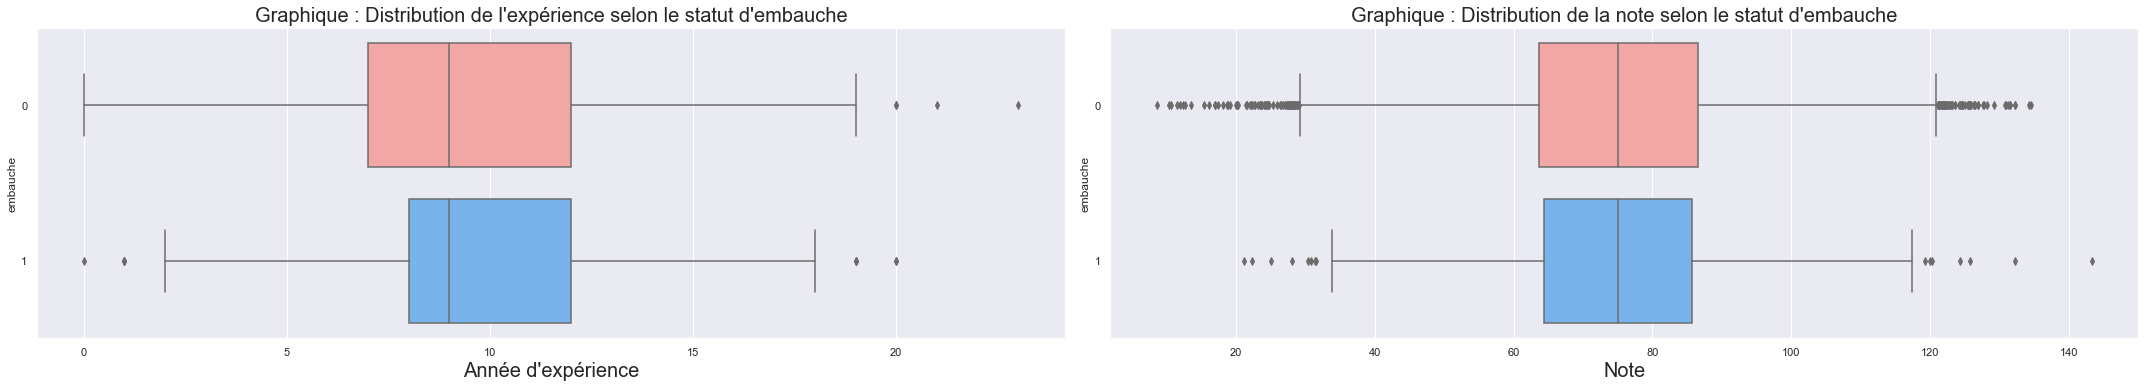

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(30, 5))
fig.tight_layout()
sns.set(style="darkgrid")
sns.boxplot(ax = axes[0], data=df, y='embauche', x='exp', palette={'#ff9999','#66b3ff'})
axes[0].set_title("Graphique : Distribution de l'expérience selon le statut d'embauche", fontsize=20, )
axes[0].set_xlabel(xlabel="Année d'expérience", fontsize=20)

sns.boxplot(ax = axes[1], data=df, y='embauche', x='note', palette={'#ff9999','#66b3ff'})
axes[1].set_title("Graphique : Distribution de la note selon le statut d'embauche", fontsize=20, )
axes[1].set_xlabel(xlabel="Note", fontsize=20)

## IV : Modélisation 

In [110]:
var_cat = ['cheveux','sexe','diplome', 'specialite']
var_num = ['age', 'exp', 'salaire', 'note', 'embauche']


In [111]:
## Onehot encodage des variables

def onehot(onehot_df, df, column_name):
       onehot_df[column_name] = df[column_name]

       dummies = pd.get_dummies(onehot_df[column_name], prefix=column_name)
       onehot_df = onehot_df.join(dummies)
       onehot_df = onehot_df.drop([column_name], axis=1)
       onehot_df = onehot_df.iloc[:,:-1]
       return onehot_df

def df_onehot(df):
       onehot_df = pd.DataFrame(index = df.index) 
       var_cat = ['cheveux','sexe','diplome', 'specialite']
       for var in var_cat:
              onehot_df = onehot(onehot_df, df, var)
       return onehot_df


df_num = df[var_num]

df2 = pd.concat([df_onehot(df), df_num], axis=1)

In [112]:
## Séparation de la base en échantillon train et test
y = df2['embauche']
X = df2.drop(['embauche'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [113]:
## Standardisation des variables 
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [114]:
## Sérialiser les échantillons
with open('train1.pickle', 'wb') as f1:
    pickle.dump([X_train_s, y_train], f1)

with open('test1.pickle', 'wb') as f2:
    pickle.dump([X_test_s, y_test], f2)

In [115]:
## Charger les échantillons
with open('train1.pickle', 'rb') as f1:
    X_train_s, y_train = pickle.load(f1)

with open('test1.pickle', 'rb') as f2:
    X_test_s, y_test = pickle.load(f2)

In [116]:
print((X_train_s.shape, y_train.shape), (X_test_s.shape, y_test.shape))

((14000, 14), (14000,)) ((6000, 14), (6000,))


In [129]:
## Fonction pour récupérer l'AUC du modèle

def AUC_score_model(model, X_test_, y_test_):
   
    y_test_pred = model.predict(X_test_)


    y_test_pred_proba = model.predict_proba(X_test_)[:,1]

    # Calcul de l'AUC et du taux de bon classement (accuracy)  
    accuracy = accuracy_score(y_test_, y_test_pred)   

    AUC = roc_auc_score(y_test_, y_test_pred_proba)

    print('***********************************************************')
    print("Taux de bon classement - data : %.2f%%" % (accuracy * 100.0))
    print('***********************************************************')
    print("AUC - data : %.2f%%" % (AUC * 100.0))
    print('***********************************************************')
    
    # Construction de la courbe Roc
    bc = BinaryClassification(y_test_, y_test_pred_proba, labels=["Class 1", "Class 2"])
    plt.figure(figsize=(15,8))
    bc.plot_roc_curve()
    plt.show()  

    return {"proba":y_test_pred_proba, "class":y_test_pred}

### IV.1 : Modèle xgboost

In [150]:
## Setting des parametères optimisiables

parameters_1 = {'learning_rate': [0.01, 0.03, 0.1, 0.2],
              'max_depth': range(3,9,2),
              'min_child_weight':range(3,9,3),
              'subsample':[i/10.0 for i in range(6,8,3)],
              'n_estimators': range(50,200,50), 
              }

parameters_2 = {'learning_rate': [0.01, 0.03, 0.1, 0.2],
              'max_depth': range(3,10,3),
              'min_child_weight':range(1,8,2),
              'subsample':[i/10.0 for i in range(6,10,2)],
              'n_estimators': range(50,200,50), 
              }

parameters = parameters_1

In [151]:
## Cross validation et Modélisation 

start_time = time.time()

eval_set = [(X_train_s, y_train), (X_test_s, y_test)]


xgb_model =  xgb.XGBClassifier(use_label_encoder=False, seed=1)

optXgb = GridSearchCV(xgb_model_1, parameters, n_jobs=-1, 
                       cv=5, 
                       scoring='roc_auc',
                       verbose=1, refit=True)

optXgb.fit(X_train_s, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

print(time.time()-start_time)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
79.89712190628052


In [152]:
## Meilleurs paramètres 
print(optXgb.best_params_, optXgb.best_score_)

{'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': 0.6} 0.8751339544813479


***********************************************************
Taux de bon classement - data : 91.02%
***********************************************************
AUC - data : 86.52%
***********************************************************


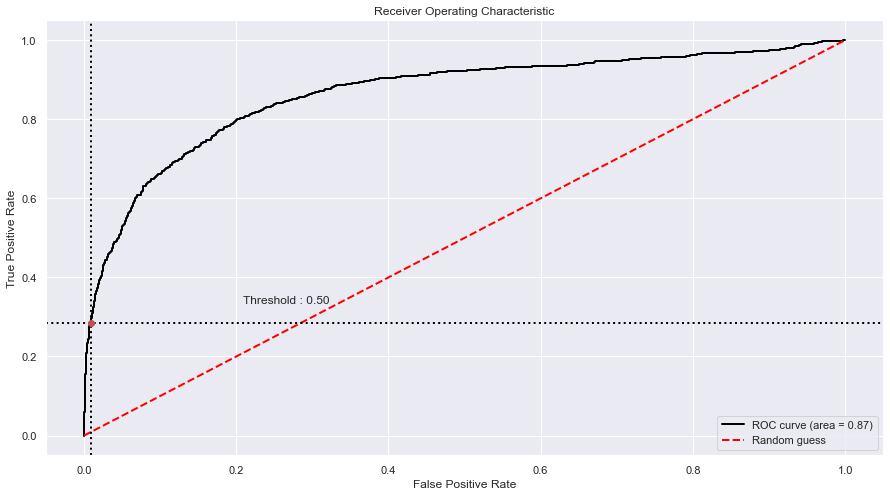

In [153]:
## Evaluation du modèle (AUC et TBC)
y_test_pred_optXgb = AUC_score_model(optXgb, X_test_s, y_test) 

In [154]:
### Statistiques de précision
print(classification_report(y_test_pred_optXgb['class'], y_test))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5759
           1       0.28      0.81      0.42       241

    accuracy                           0.91      6000
   macro avg       0.64      0.86      0.69      6000
weighted avg       0.96      0.91      0.93      6000



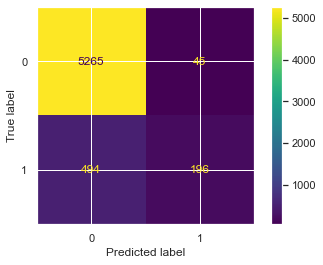

In [155]:
## Matrice de confusion
plot_confusion_matrix(optXgb, X_test_s, y_test)

***********************************************************
Taux de bon classement - data : 91.02%
***********************************************************
AUC - data : 86.52%
***********************************************************


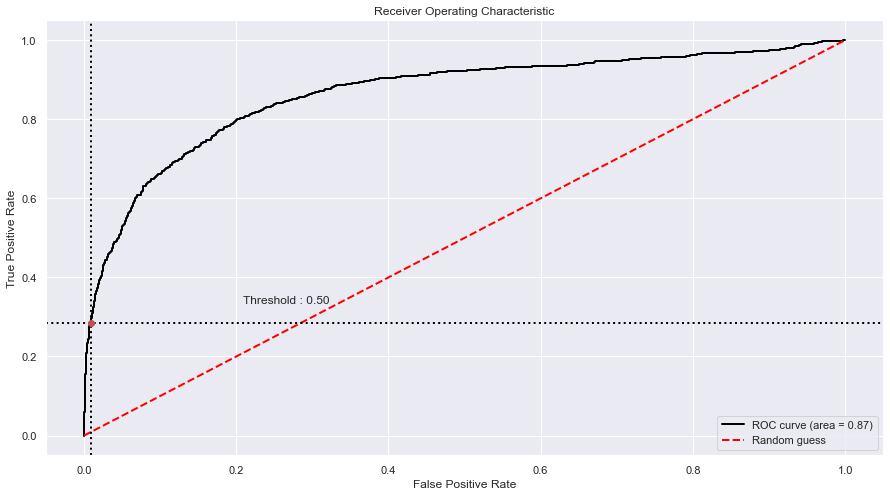

In [157]:
## Evaluation du modèle (AUC et TBC)
_=AUC_score_model(optXgb, X_test_s, y_test)              

Text(0.5, 1.0, 'XGBoost Classification Error')

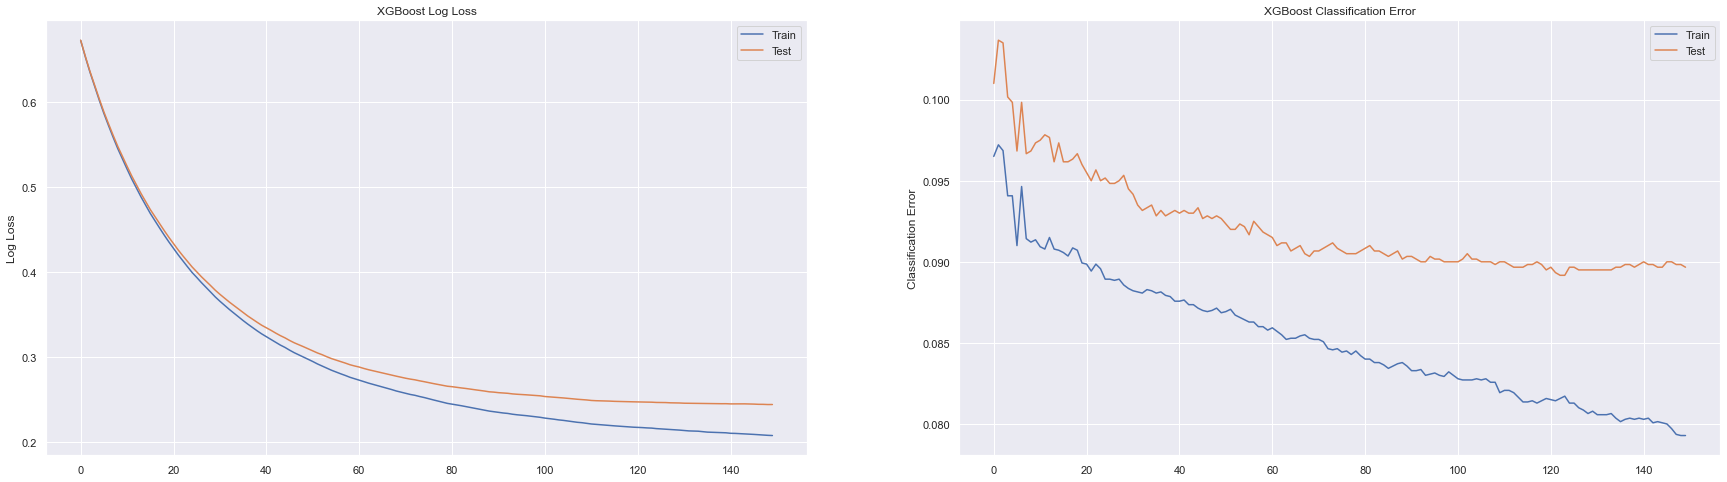

In [161]:
### Construction de la courbe d'apprentissage
results = optXgb_1.best_estimator_.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(1,2,figsize=(30, 8))
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Test')
ax[0].legend()

ax[0].set_ylabel('Log Loss')
ax[0].set_title('XGBoost Log Loss')

## Construction de la courbe d'erreur
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('XGBoost Classification Error')

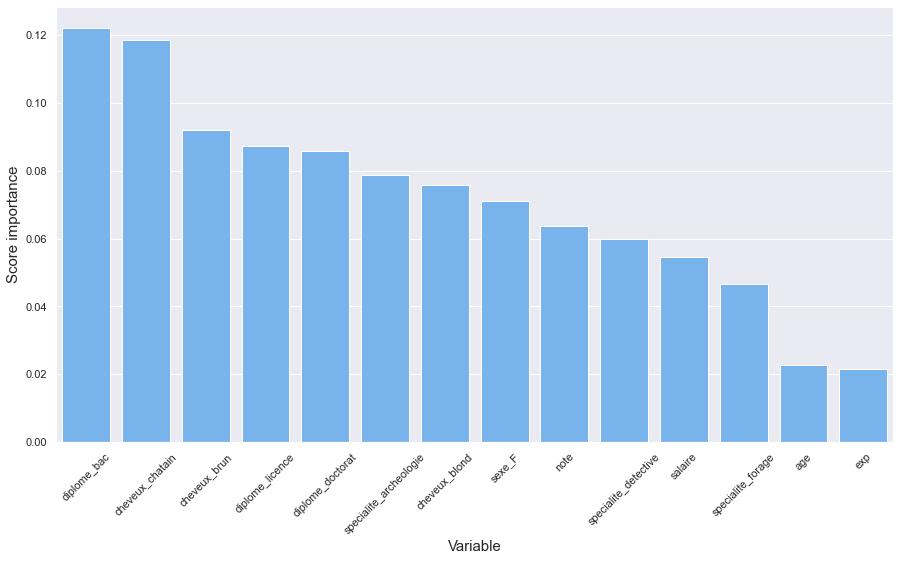

In [162]:
## Variable importance
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': optXgb_1.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

barplot_cust_1(importance_df, "Variable", "Importance", lab=False, label_y='Score importance')

### IV.2. Modèle randomForest

In [135]:
start_time = time.time()

eval_set = [(X_train_s, y_train), (X_test_s, y_test)]

parameters_rf = {
    'max_depth': [10,15,20],
    'max_features': [2, 3, 4, 5,6 ],
    'n_estimators': [50, 100, 150, 200],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [3,4,5,6]
}

parameters_rf = {
    'max_depth': [10,15],
    'max_features': [3, 4, 5],
    'n_estimators': [100, 150, 200],
    'min_samples_leaf': [4, 5, 6],
    'min_samples_split': [3,4,5,6]
}

In [136]:
## Cross validation et modélisation

rf_model = RandomForestClassifier(random_state=42)

optRf = GridSearchCV(rf_model, parameters_rf, n_jobs=-1, 
                       cv=8, 
                       scoring='roc_auc',
                       verbose=1, refit=True)

## Fit sur les paramètres optimisées
optRf.fit(X_train_s, y_train)

print(time.time()-start_time)

Fitting 8 folds for each of 216 candidates, totalling 1728 fits
493.03060698509216


In [137]:
## Meilleurs paramètres
print(optRf.best_params_, optRf.best_score_)

{'max_depth': 15, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 150} 0.8770177821986198


***********************************************************
Taux de bon classement - data : 90.92%
***********************************************************
AUC - data : 86.93%
***********************************************************


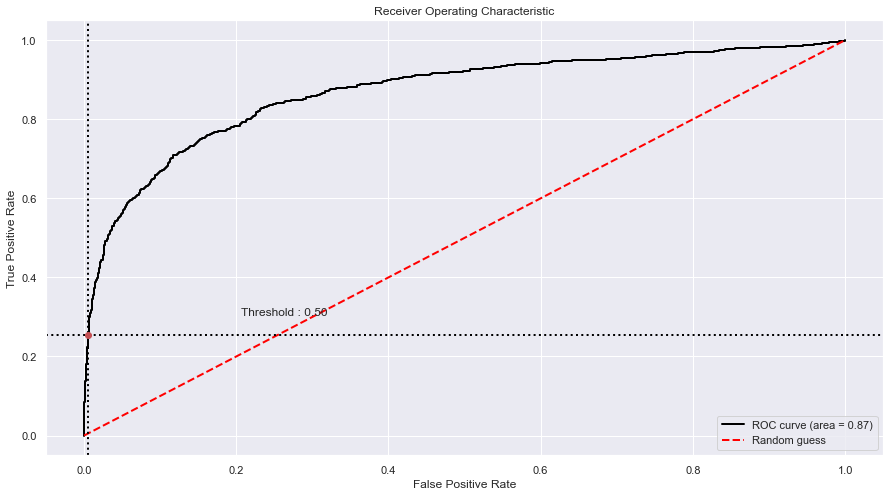

In [141]:
## Evaluation du modèle (AUC et TBC)
_=AUC_score_model(optRf, X_test_s, y_test)

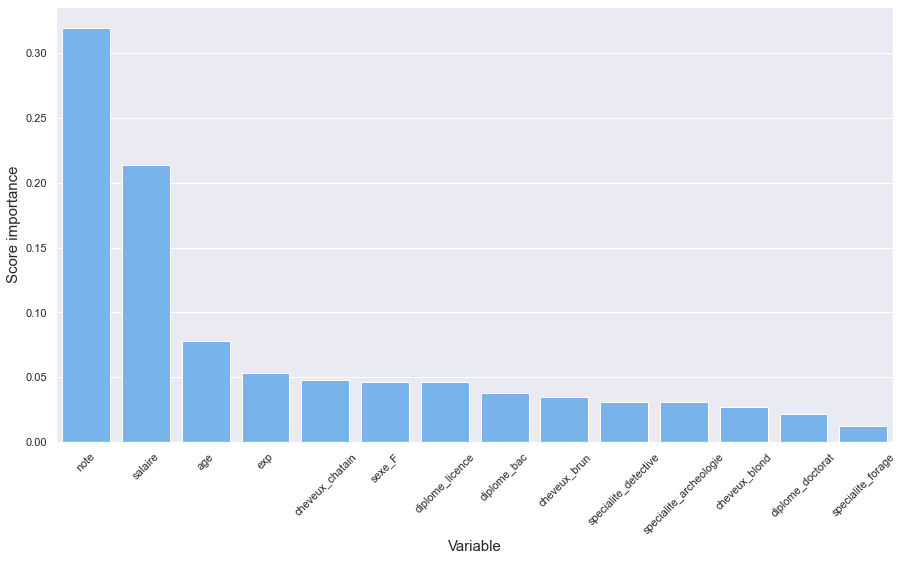

In [140]:
## Variable importance
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': optRf.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

barplot_cust_1(importance_df, "Variable", "Importance", lab=False, label_y='Score importance')

### IV.3. Light Gradient Boosting model

In [142]:
## Rétraicissement du learning rate
def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

## Setting des paramètres de base
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            'eval_names': ['valid'],
            'verbose': False,
            'silent' : True,
            'categorical_feature': 'auto'}

In [143]:
## Setting des parametères optimisiables
nb = 15
parameters_lgb ={'num_leaves': list(sp_randint(6, 50).rvs(nb)), 
                'min_child_samples': list(sp_randint(100, 500).rvs(nb)), 
                'min_child_weight': [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3],
                'max_depth': list(sp_randint(10, 20).rvs(nb)),
                'subsample': list(sp_uniform(loc=0.2, scale=0.8).rvs(nb)), 
                'colsample_bytree': list(sp_uniform(loc=0.4, scale=0.6).rvs(nb)),
                'reg_alpha': list(sp_randint(4, 50).rvs(nb)),
                'reg_lambda': [1, 5, 10, 50, 100]
                }

nb = 10
parameters_lgb ={'num_leaves': list(sp_randint(6, 50).rvs(nb)), 
                'min_child_samples': list(sp_randint(100, 500).rvs(nb)), 
                'max_depth': list(sp_randint(10, 20).rvs(nb)),
                'subsample': list(sp_uniform(loc=0.2, scale=0.8).rvs(nb)),
                'n_estimators': list(sp_randint(100, 200).rvs(nb))
                }

In [1]:
## Cross validation et modélisation
start_time = time.time()

eval_set_=[(X_train_s, y_train), (X_test_s, y_test)]

lgb_model = lgb.LGBMClassifier(random_state=314, verbose=0, metric='None', n_jobs=-1, force_row_wise=True)

optLgb = RandomizedSearchCV(
    estimator=lgb_model, 
    param_distributions=parameters_lgb, 
    scoring='roc_auc',
    cv=8,
    refit=True,
    random_state=314,
    verbose=True)


# optLgb.fit(X_train_s, y_train, early_stopping_rounds=10, eval_set=eval_set_, eval_metric=["error", "logloss"], callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])
optLgb.fit(X_train_s, y_train , eval_set=eval_set_, eval_metric=["error", "logloss"], callbacks=[lgb.early_stopping(10)])

print(time.time()-start_time)

NameError: name 'time' is not defined

In [145]:
## Meilleurs paramètres 
print('Best score reached: {} with params: {} '.format(optLgb.best_score_, optLgb.best_params_))                           

Best score reached: 0.8733282769030377 with params: {'subsample': 0.8432380130464356, 'num_leaves': 20, 'n_estimators': 155, 'min_child_samples': 168, 'max_depth': 16} 


***********************************************************
Taux de bon classement - data : 91.25%
***********************************************************
AUC - data : 86.45%
***********************************************************


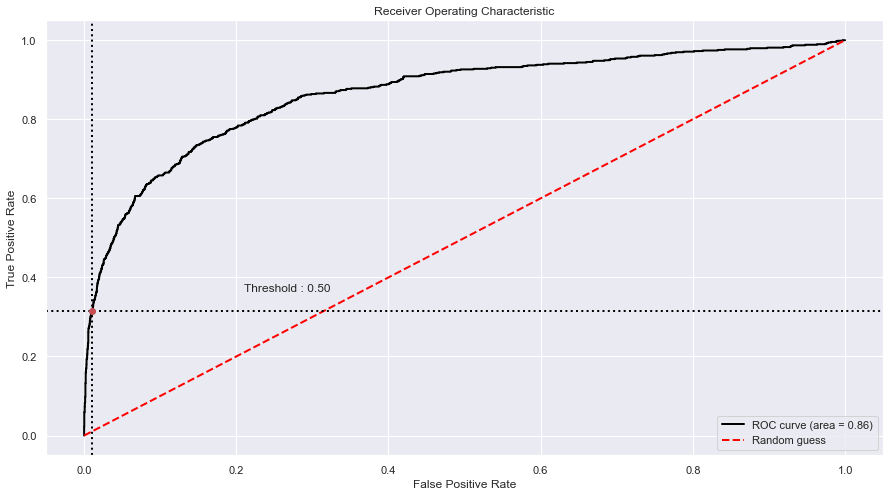

In [146]:
## Evaluation du modèle
_=AUC_score_model(optLgb, X_test_s, y_test)

Text(0.5, 1.0, 'Lightgbm Classification Error')

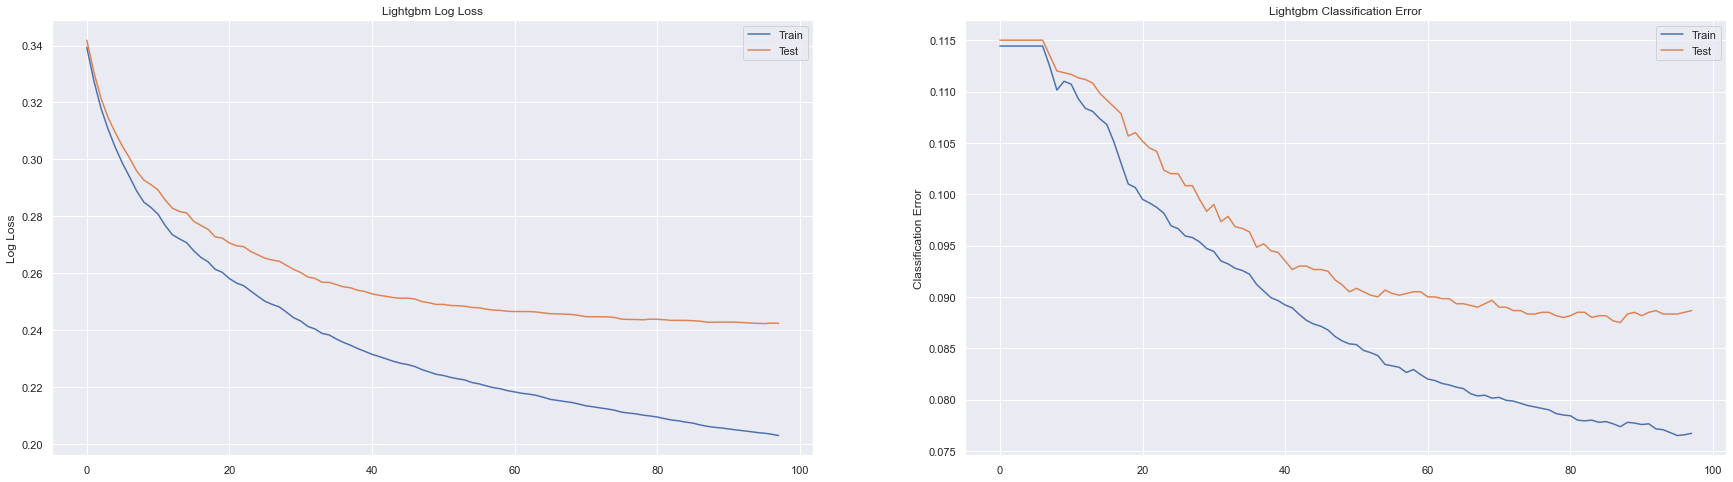

In [211]:
## Construction de la courbe d'apprentissage
results = optLgb.best_estimator_.evals_result_

epochs = len(results['training']['binary_error'])

x_axis = range(0, epochs)

fig, ax = plt.subplots(1,2,figsize=(30, 8))
ax[0].plot(x_axis, results['training']['binary_logloss'], label='Train')
ax[0].plot(x_axis, results['valid_1']['binary_logloss'], label='Test')
ax[0].legend()

ax[0].set_ylabel('Log Loss')
ax[0].set_title('Lightgbm Log Loss')

## Construction de la courbe d'erreur
ax[1].plot(x_axis, results['training']['binary_error'], label='Train')
ax[1].plot(x_axis, results['valid_1']['binary_error'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('Lightgbm Classification Error')

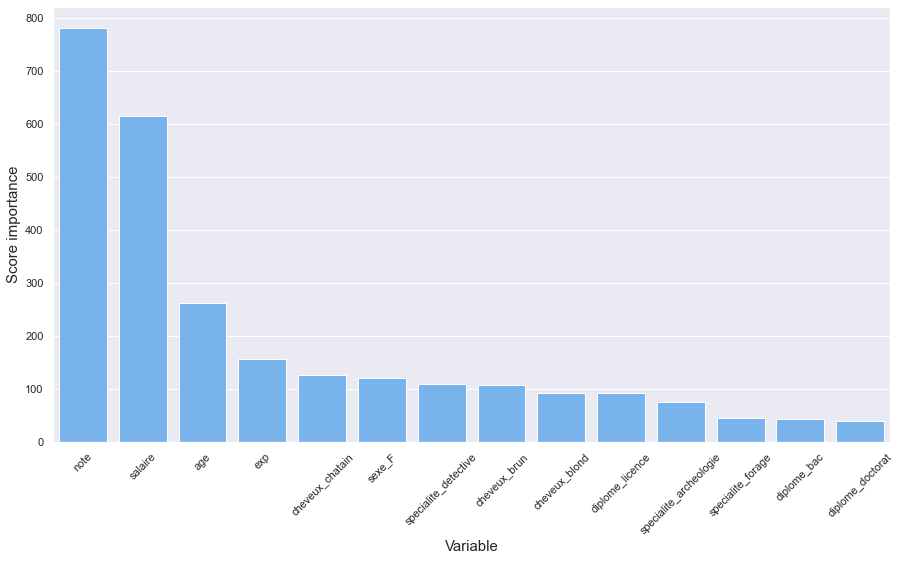

In [204]:
## Variable importance
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': optLgb.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

barplot_cust_1(importance_df, "Variable", "Importance", lab=False, label_y='Score importance')

### IV.3. Modèle Ada boosting

In [1]:
## Paramètres du modèle
parameters = {'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3],
              'n_estimators': range(50,300,25)
              }

In [4]:
## Cross validation et Modélisation 
start_time = time.time()

# base_estimator : LogisticRegression   DecisionTreeClassifier
adaboost_model =  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=12, loss='exponential')

optAdaboost = GridSearchCV(adaboost_model, parameters, n_jobs=-1, 
                       cv=8, 
                       scoring='roc_auc',
                       verbose=1, refit=True)

## Fit sur les paramètres optimisées
optAdaboost.fit(X_train_s, y_train_s)

print(time.time()-start_time)

TypeError: __init__() got an unexpected keyword argument 'loss'

In [72]:
## Meilleurs paramètres
print(optAdaboost.best_params_, optAdaboost.best_score_)

{'learning_rate': 0.01, 'n_estimators': 50} 0.6770886342447471


***********************************************************
Taux de bon classement - data : 86.05%
***********************************************************
AUC - data : 65.70%
***********************************************************


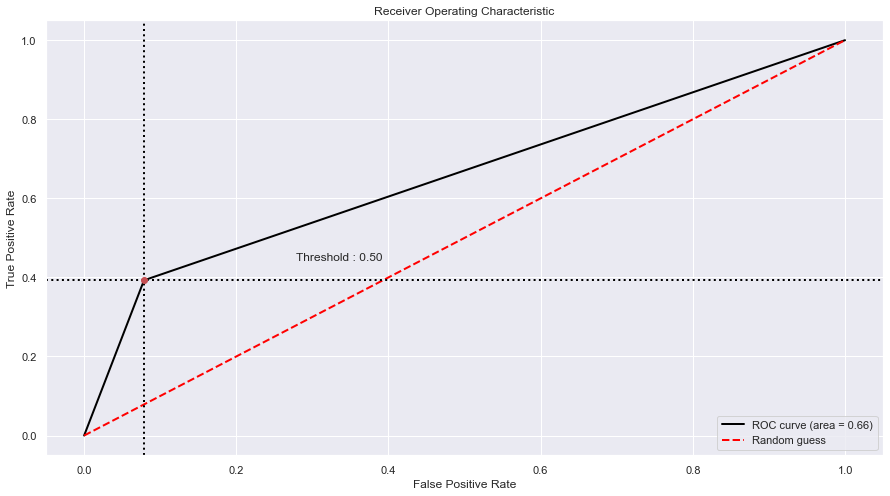

array([2.22044605e-16, 1.00000000e+00, 2.22044605e-16, ...,
       2.22044605e-16, 2.22044605e-16, 2.22044605e-16])

In [73]:
## Evaluation du modèle (AUC et TBC)
AUC_score_model(optAdaboost, X_test_s, y_test)

In [ ]:
## Variable importance
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': optAdaboost.best_estimator_.feature_importances_  
}).sort_values('Importance', ascending=False)

barplot_cust_1(importance_df, "Variable", "Importance", lab=False, label_y='Score importance')

### IV.4. Réseaux de neurones

In [50]:
## Paramètres du modèle
tf.random.set_seed(12)
early = EarlyStopping(monitor='val_loss', patience=2)
opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)
epochs_ = 40

In [51]:
## Construction du modèle
optNN = Sequential()
optNN.add(Dense(78,activation='relu'))
optNN.add(Dropout(0.2))
optNN.add(Dense(39,activation='relu'))
optNN.add(Dropout(0.5))
optNN.add(Dense(19,activation='relu'))
optNN.add(Dropout(0.5))
optNN.add(Dense(1,activation='sigmoid'))
optNN.compile(loss="binary_crossentropy", optimizer='adam', metrics=['AUC'])

In [52]:
## Exécution du modèle
optNN.fit(x=X_train_s,y=y_train,epochs=epochs_,batch_size=256,validation_data=(X_test_s,y_test), callbacks=[early])

Epoch 1/40
55/55 [==============================] - 1s 10ms/step - loss: 0.4733 - auc: 0.5041 - val_loss: 0.3588 - val_auc: 0.5455
Epoch 2/40
55/55 [==============================] - 0s 6ms/step - loss: 0.3993 - auc: 0.5327 - val_loss: 0.3522 - val_auc: 0.6144
Epoch 3/40
55/55 [==============================] - 0s 7ms/step - loss: 0.3824 - auc: 0.5610 - val_loss: 0.3428 - val_auc: 0.6553
Epoch 4/40
55/55 [==============================] - 1s 10ms/step - loss: 0.3772 - auc: 0.5721 - val_loss: 0.3358 - val_auc: 0.6915
Epoch 5/40
55/55 [==============================] - 0s 9ms/step - loss: 0.3662 - auc: 0.6023 - val_loss: 0.3299 - val_auc: 0.7154
Epoch 6/40
55/55 [==============================] - 0s 9ms/step - loss: 0.3610 - auc: 0.6208 - val_loss: 0.3245 - val_auc: 0.7342
Epoch 7/40
55/55 [==============================] - 0s 9ms/step - loss: 0.3550 - auc: 0.6406 - val_loss: 0.3172 - val_auc: 0.7547
Epoch 8/40
55/55 [==============================] - 1s 9ms/step - loss: 0.3467 - auc: 0.

Text(0.5, 1.0, 'Loss train-test')

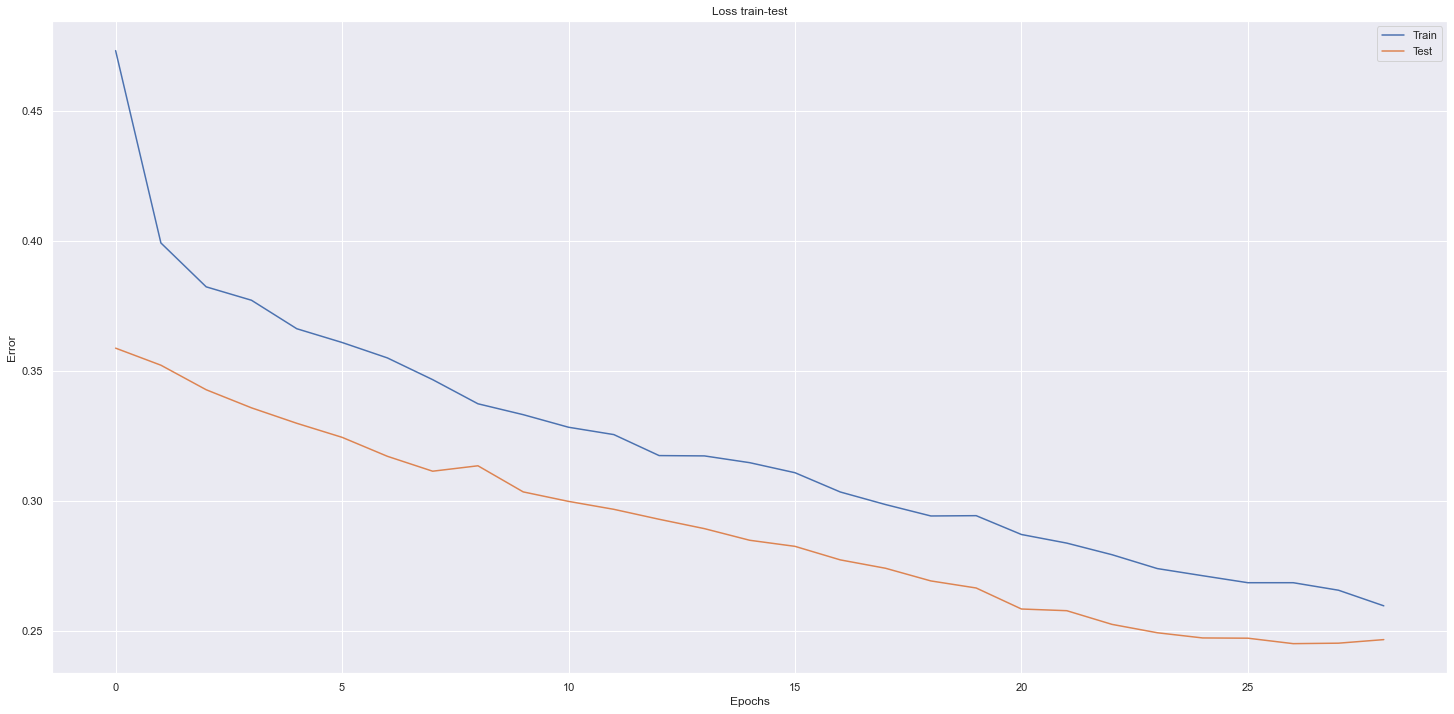

In [49]:
## Courbe d'apprentissage
losses = pd.DataFrame(optNN.history.history)
x_axis = range(0, losses.shape[0])

fig, ax = plt.subplots(figsize=(25, 12))
ax.plot(x_axis, losses['loss'], label='Train')
ax.plot(x_axis, losses['val_loss'], label='Test')
ax.legend()

ax.set_xlabel('Epochs')
ax.set_ylabel('Error')
ax.set_title('Loss train-test')

In [53]:
## Evaluation du modèle (AUC et TBC)
def AUC_score_model_nn(model, X_test_, y_test_):

    # Calcul de l'AUC et du taux de bon classement (accuracy) 
    y_test_pred_proba = model.predict(X_test_)

    AUC = roc_auc_score(y_test_, y_test_pred_proba)

    print('***********************************************************')
    print("AUC - data : %.2f%%" % (AUC * 100.0))
    print('***********************************************************')
    
    # Construction de la courbe Roc
    bc = BinaryClassification(y_test_, y_test_pred_proba, labels=["Class 1", "Class 2"])
    plt.figure(figsize=(15,8))
    bc.plot_roc_curve()
    plt.show() 

    return y_test_pred_proba

***********************************************************
AUC - data : 86.25%
***********************************************************


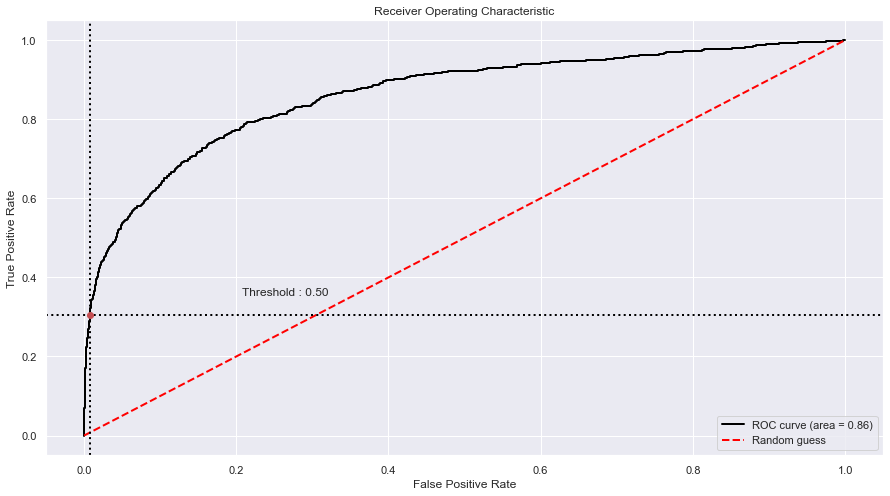

In [147]:
_=AUC_score_model_nn(optNN, X_test_s, y_test)

### IV.4. Modèle stacking

##### a. Prediction pour modèle de niveau 0

In [175]:
def data_pred(X):
    X_pred=pd.DataFrame()
    X_pred['xgboost_model'] = optXgb.predict_proba(X)[:,1]   
    #X_pred['rf_model'] = optRf.predict_proba(X)[:,1]  
    X_pred['lgb_model'] = optLgb.predict_proba(X)[:,1]  
    X_pred['nn_model'] = optNN.predict(X)
    return X_pred

In [176]:
X_train_stack = data_pred(X_train_s).values
X_test_stack = data_pred(X_test_s).values

##### b. Construction du meta modèle de niveau 1

In [183]:
## Paramètres du modèle
tf.random.set_seed(12)
early = EarlyStopping(monitor='val_loss', patience=5)
opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
epochs_ = 40

## Construction du modèle
meta_model = Sequential()
meta_model.add(Dense(156,activation='relu'))
meta_model.add(Dropout(0.2))
meta_model.add(Dense(78,activation='relu'))
meta_model.add(Dropout(0.5))
meta_model.add(Dense(39,activation='relu'))
meta_model.add(Dropout(0.5))
meta_model.add(Dense(19,activation='relu'))
meta_model.add(Dropout(0.5))
meta_model.add(Dense(1,activation='sigmoid'))
meta_model.compile(loss="binary_crossentropy", optimizer=opt_sgd, metrics=['AUC'])

## Exécution du modèle
meta_model.fit(x=X_train_stack,y=y_train,epochs=epochs_,batch_size=256,validation_data=(X_test_stack,y_test), callbacks=[early])

Epoch 1/40
55/55 [==============================] - 1s 5ms/step - loss: 0.6125 - auc: 0.4790 - val_loss: 0.5368 - val_auc: 0.2381
Epoch 2/40
55/55 [==============================] - 0s 3ms/step - loss: 0.4975 - auc: 0.5130 - val_loss: 0.4523 - val_auc: 0.2341
Epoch 3/40
55/55 [==============================] - 0s 2ms/step - loss: 0.4383 - auc: 0.5233 - val_loss: 0.4078 - val_auc: 0.3610
Epoch 4/40
55/55 [==============================] - 0s 3ms/step - loss: 0.4088 - auc: 0.5288 - val_loss: 0.3836 - val_auc: 0.6386
Epoch 5/40
55/55 [==============================] - 0s 4ms/step - loss: 0.3940 - auc: 0.5398 - val_loss: 0.3692 - val_auc: 0.8071
Epoch 6/40
55/55 [==============================] - 0s 3ms/step - loss: 0.3839 - auc: 0.5419 - val_loss: 0.3596 - val_auc: 0.8105
Epoch 7/40
55/55 [==============================] - 0s 2ms/step - loss: 0.3754 - auc: 0.5575 - val_loss: 0.3526 - val_auc: 0.8628
Epoch 8/40
55/55 [==============================] - 0s 2ms/step - loss: 0.3708 - auc: 0.56

***********************************************************
AUC - data : 87.16%
***********************************************************


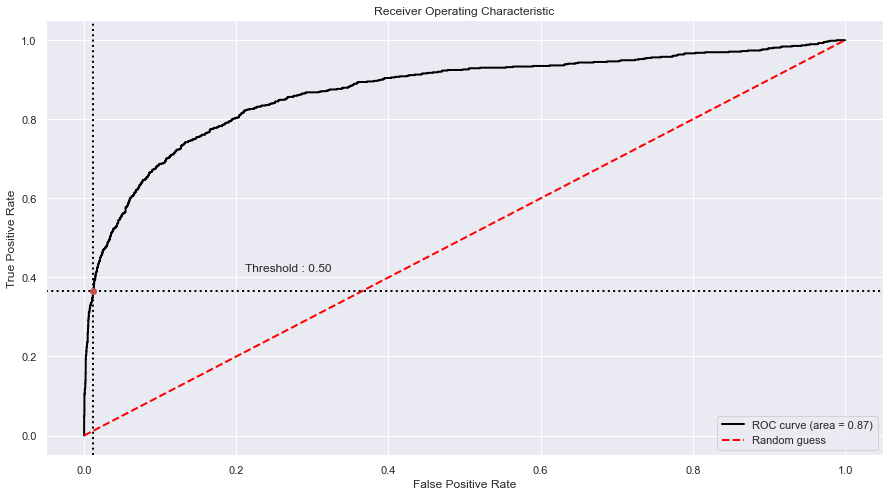

In [184]:
_=AUC_score_model_nn(meta_model, X_test_stack, y_test)

#### c. Seuil de discrimination des classes

[Text(0.5, 0, 'Probabilité')]

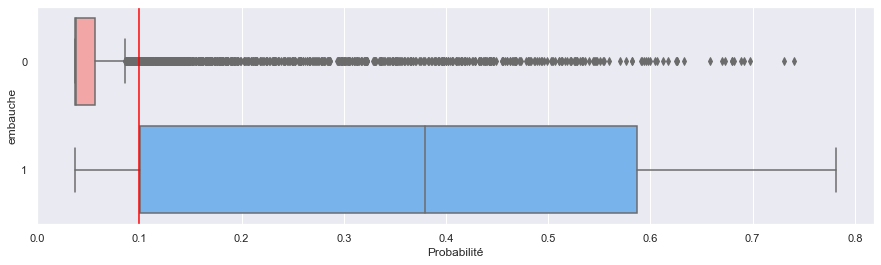

In [208]:

df_pred = pd.DataFrame()
df_pred['embauche'] = y_test
df_pred['proba'] = meta_model.predict(X_test_stack)
fig, axes = plt.subplots(figsize=(15, 4), sharey=True)
graph = sns.boxplot(ax = axes, data=df_pred, y='embauche', x ='proba' ,palette={'#ff9999','#66b3ff'})
graph.axvline(0.1, color="red")
axes.set(xlabel="Probabilité")

In [7]:
import random 
random.seed(45)
from scipy.stats import randint as sp_randint